In [1]:
import cv2
import numpy as np

from src.display import showarray
from src.feed import LiveFrameProcessor
from src.video import VideoHandler
from src.processing import features
from src.processing import Homographer, ImageMatcher
from src.processing.analyzers import SimilarityAnalyzer, CardsAnalyzer, Analyzer

In [2]:
img = cv2.imread("Easy_2_0.jpg")
board_image = cv2.imread("data/images/board.jpg")

9 / 36 contours


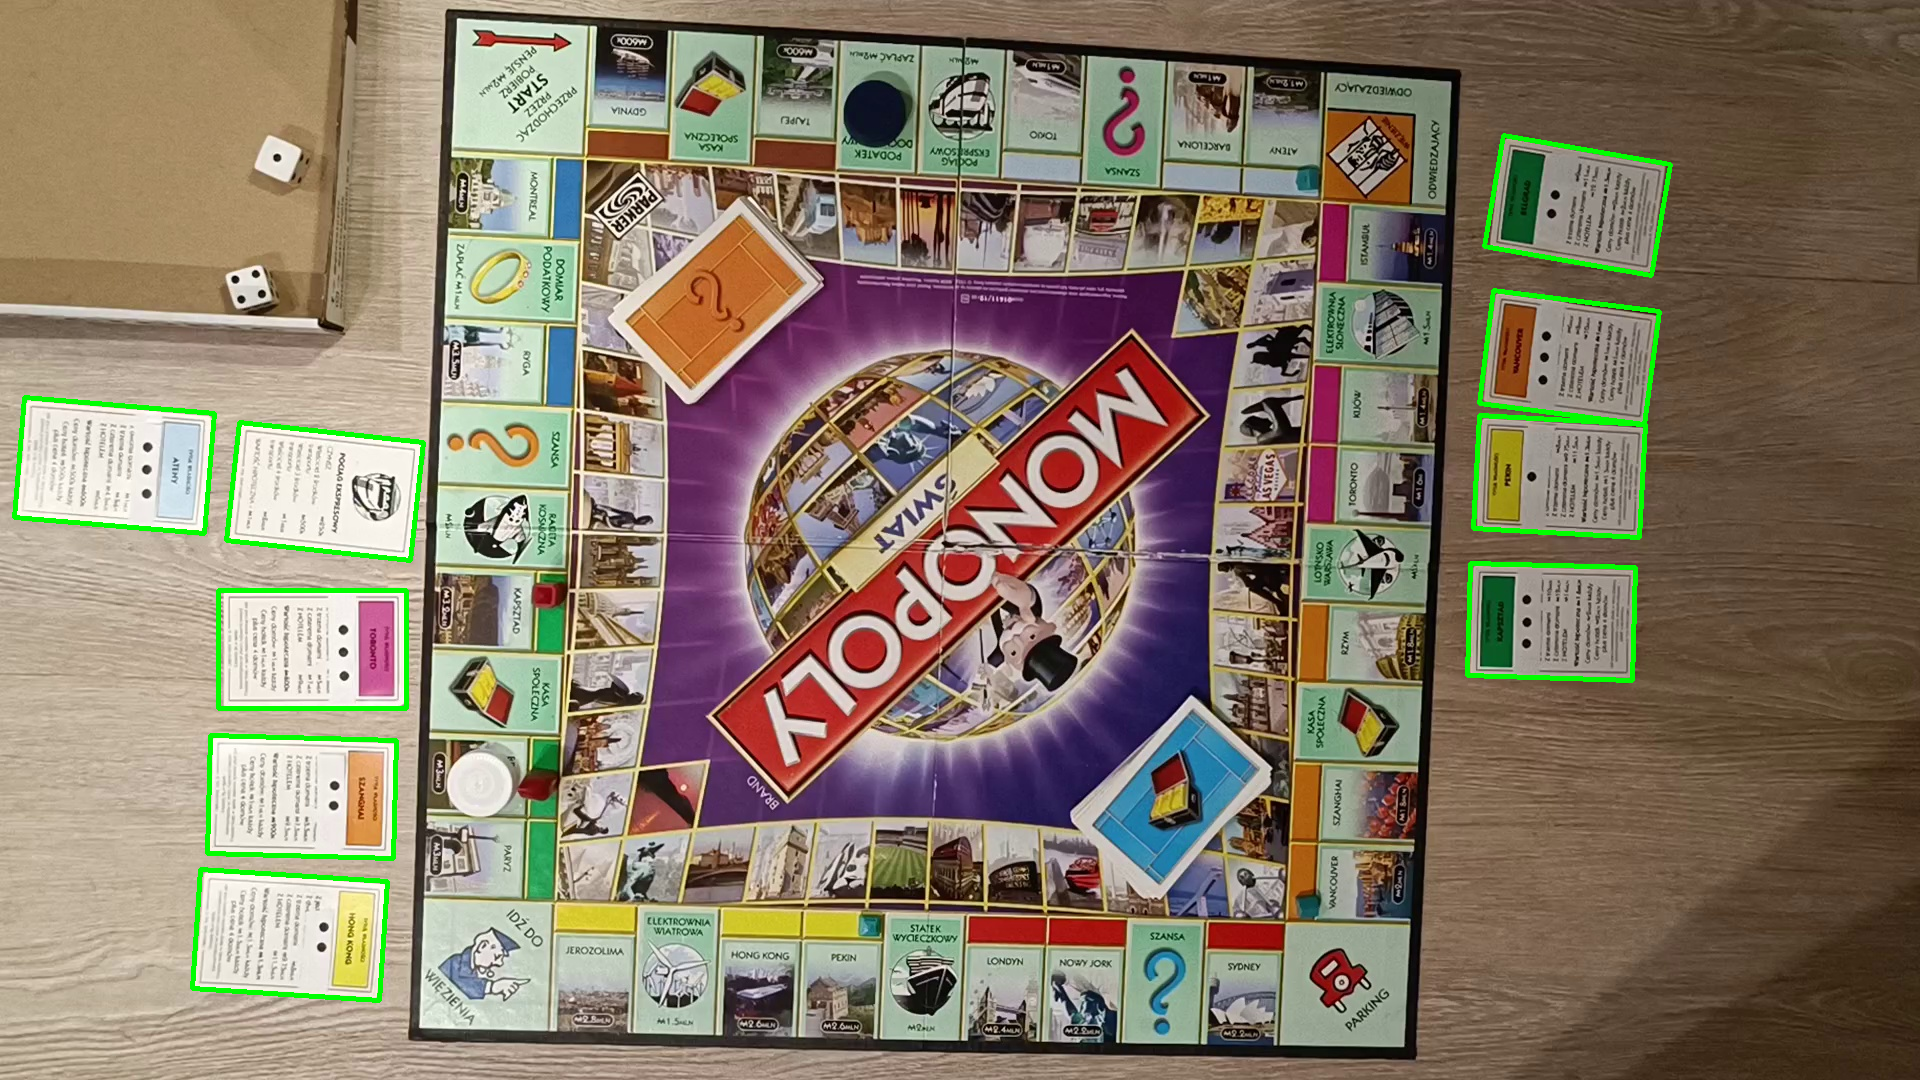

In [3]:
def is_min_area_rect_in_bounds(min_area_rect: tuple[tuple[float, float], tuple[float, float], float], area_low: int, area_high: int) -> bool:
    width = min_area_rect[1][0]
    height = min_area_rect[1][1]
    area =  width * height
    return area_low < area < area_high

def is_min_area_in_bounds_and_good_edges_ratio(contour: np.ndarray, area_low: int, area_high: int, ratio: float) -> bool:
    min_rect = cv2.minAreaRect(contour)
    width = min_rect[1][0]
    height = min_rect[1][1]
    if width == 0 or height == 0:
        return False
    actual_ratio = max(width, height) / min(width, height)
    return is_min_area_rect_in_bounds(min_rect, area_low, area_high) and abs(actual_ratio - ratio) < 0.15

CARD_RATIO = 8.5 / 5.5

def filter_contours(contours: list[np.ndarray]) -> list[np.ndarray]:
    
    return [
        contour 
        for contour in contours
        if is_min_area_in_bounds_and_good_edges_ratio(contour, 10_000, 25_000, CARD_RATIO)
    ]

edges = features.get_clear_edges(img, 130, 340)
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
filtered_contours = filter_contours(contours)
contour_boxes = [cv2.boxPoints(cv2.minAreaRect(contour)).astype(np.int32) for contour in filtered_contours]
print(f"{len(filtered_contours)} / {len(contours)} contours")
img_with_contours = cv2.drawContours(img.copy(), contour_boxes, -1, (0, 255, 0), 3)
showarray(img_with_contours)

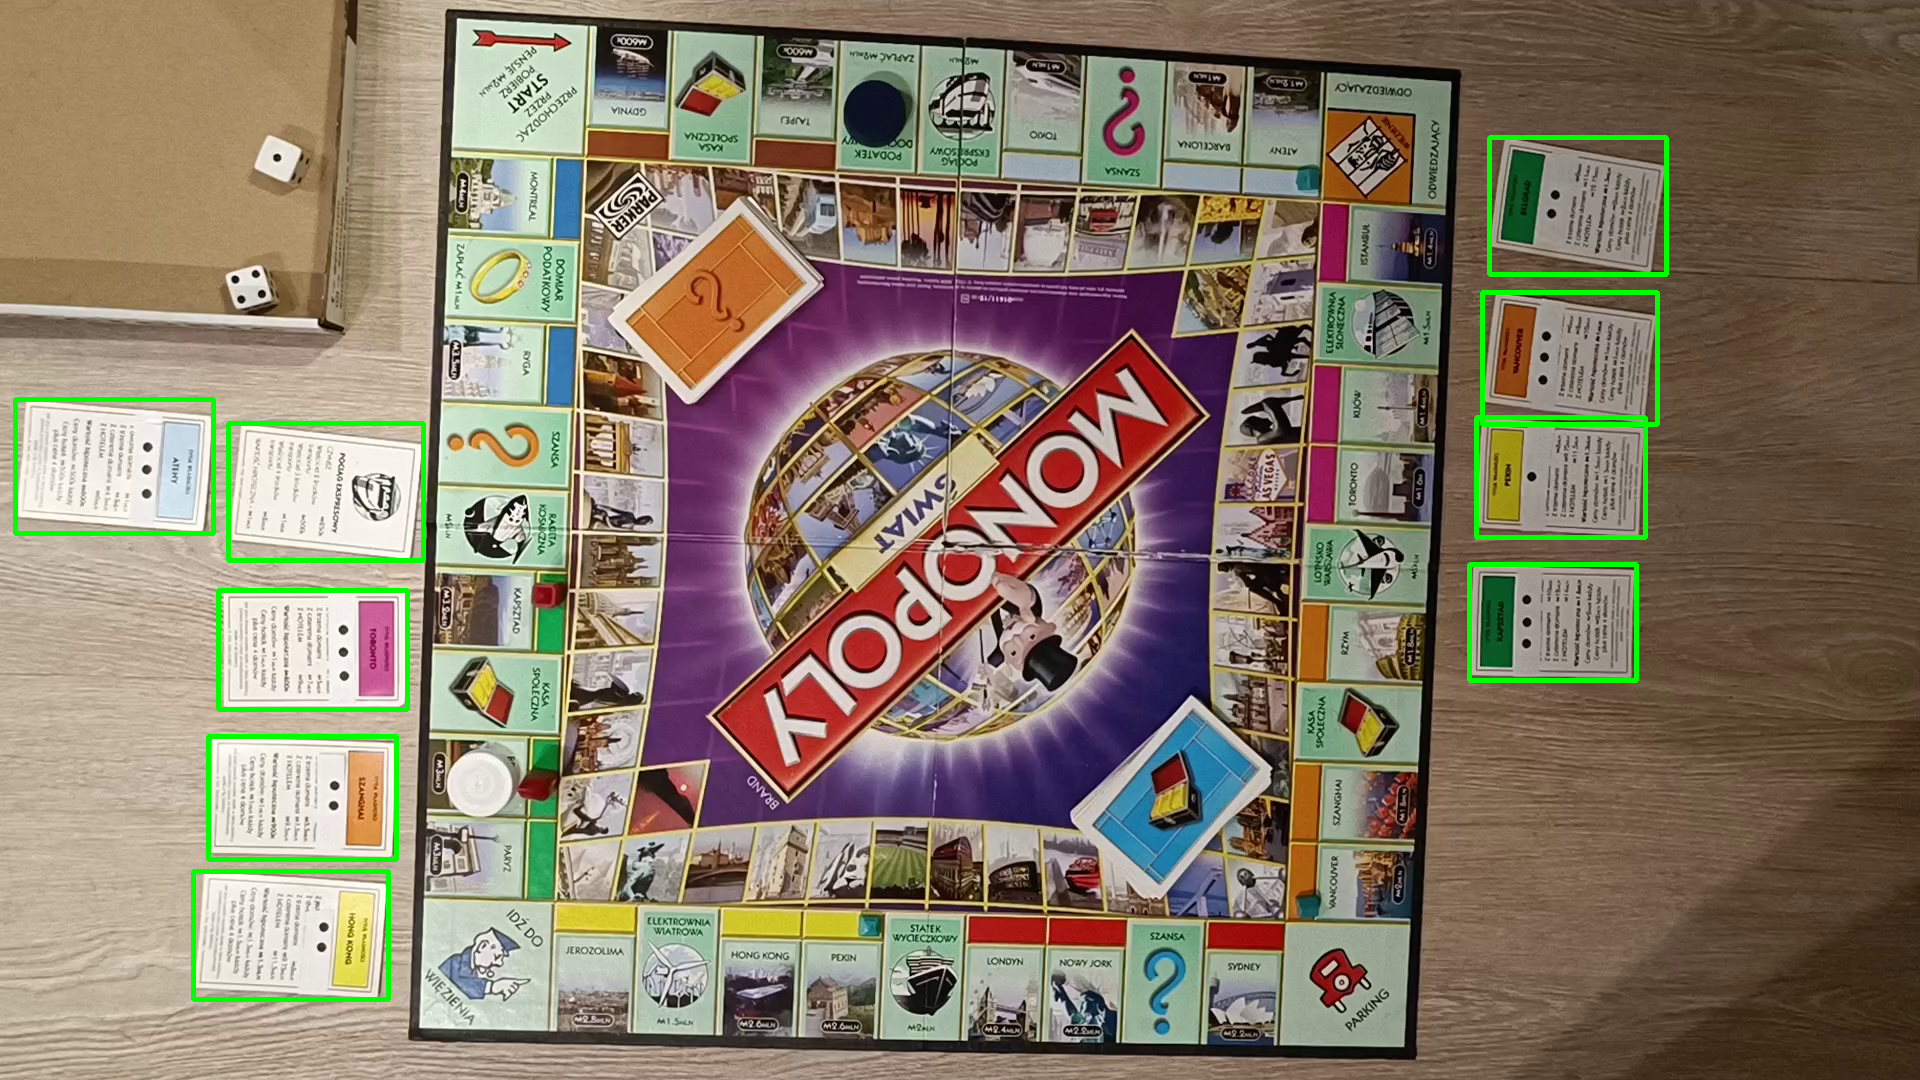

In [4]:
contours_bounding_boxes = [cv2.boundingRect(contour) for contour in filtered_contours]
img_with_contours = img.copy()
for x, y, w, h in contours_bounding_boxes:
    cv2.rectangle(img_with_contours, (x, y), (x + w, y + h), (0, 255, 0), 3)
showarray(img_with_contours)

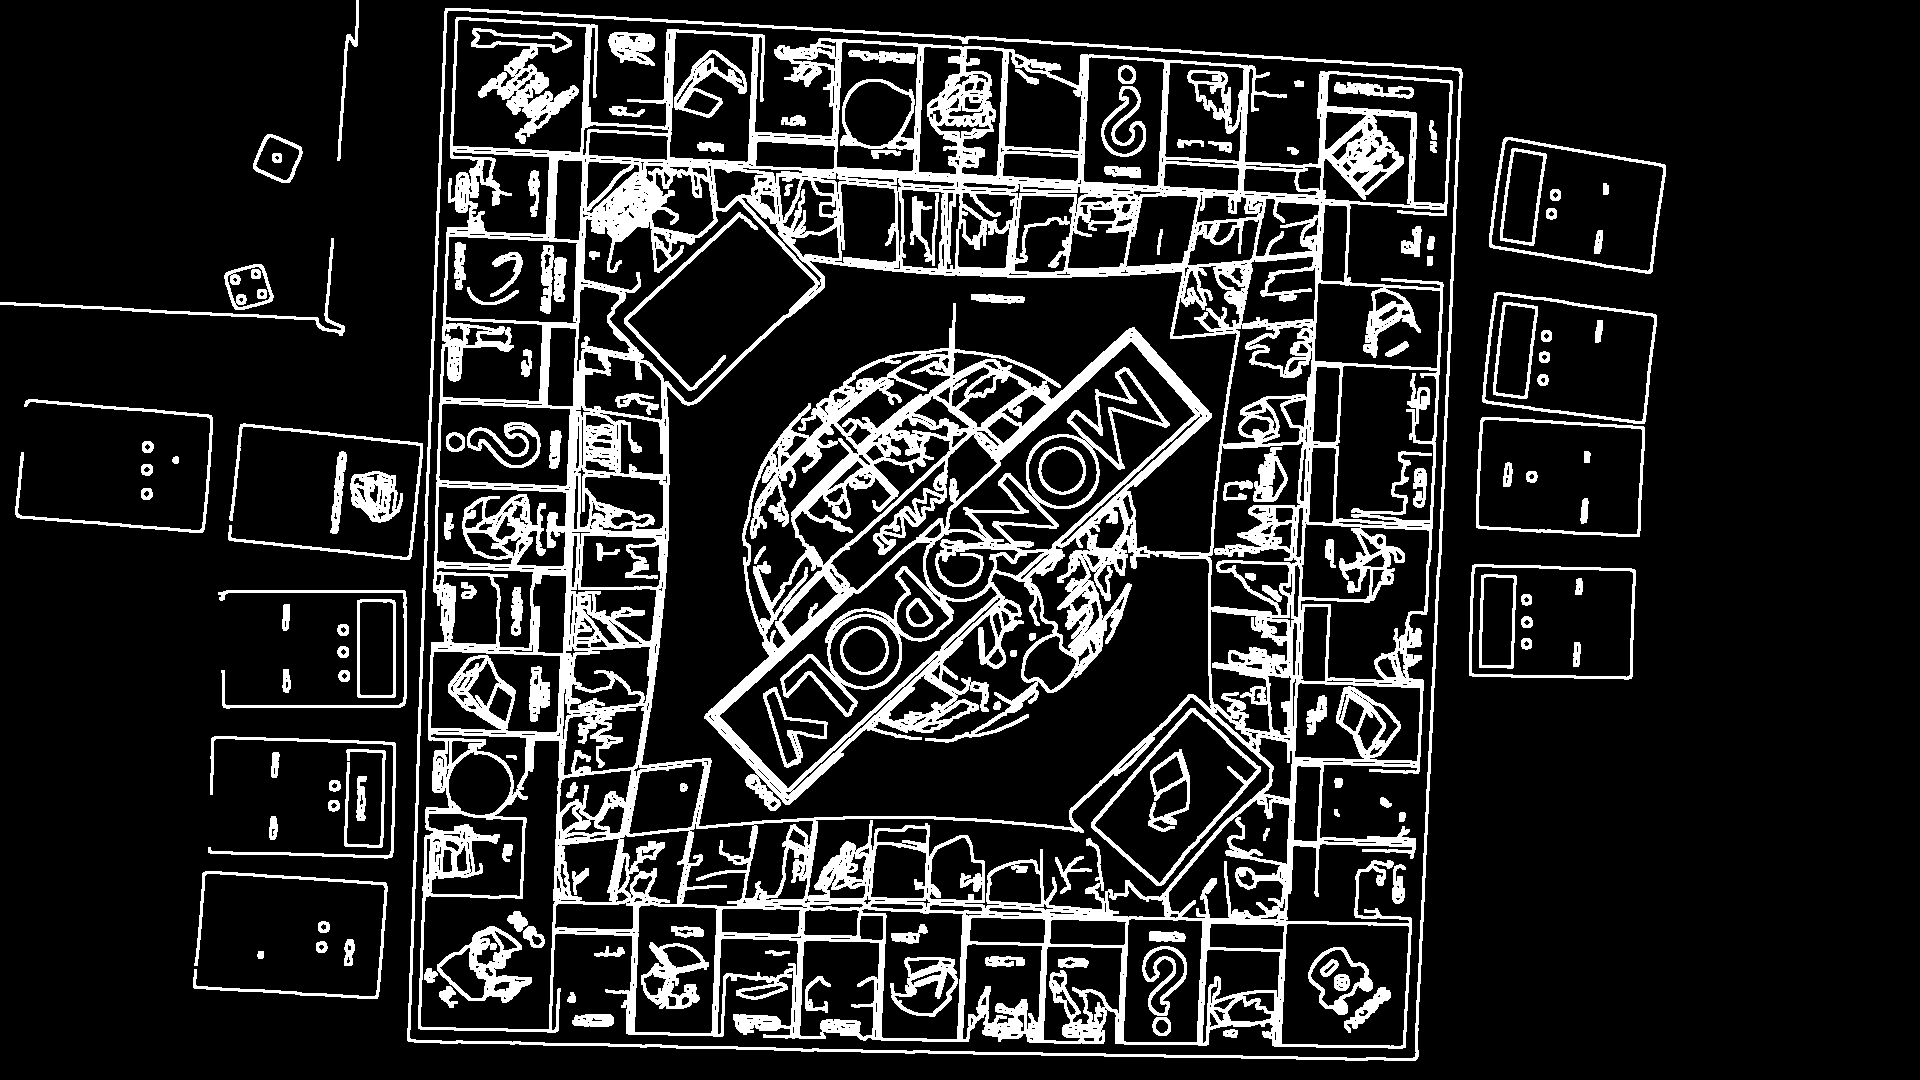

In [5]:
edges = features.get_clear_edges(img, 130, 340)
showarray(edges)

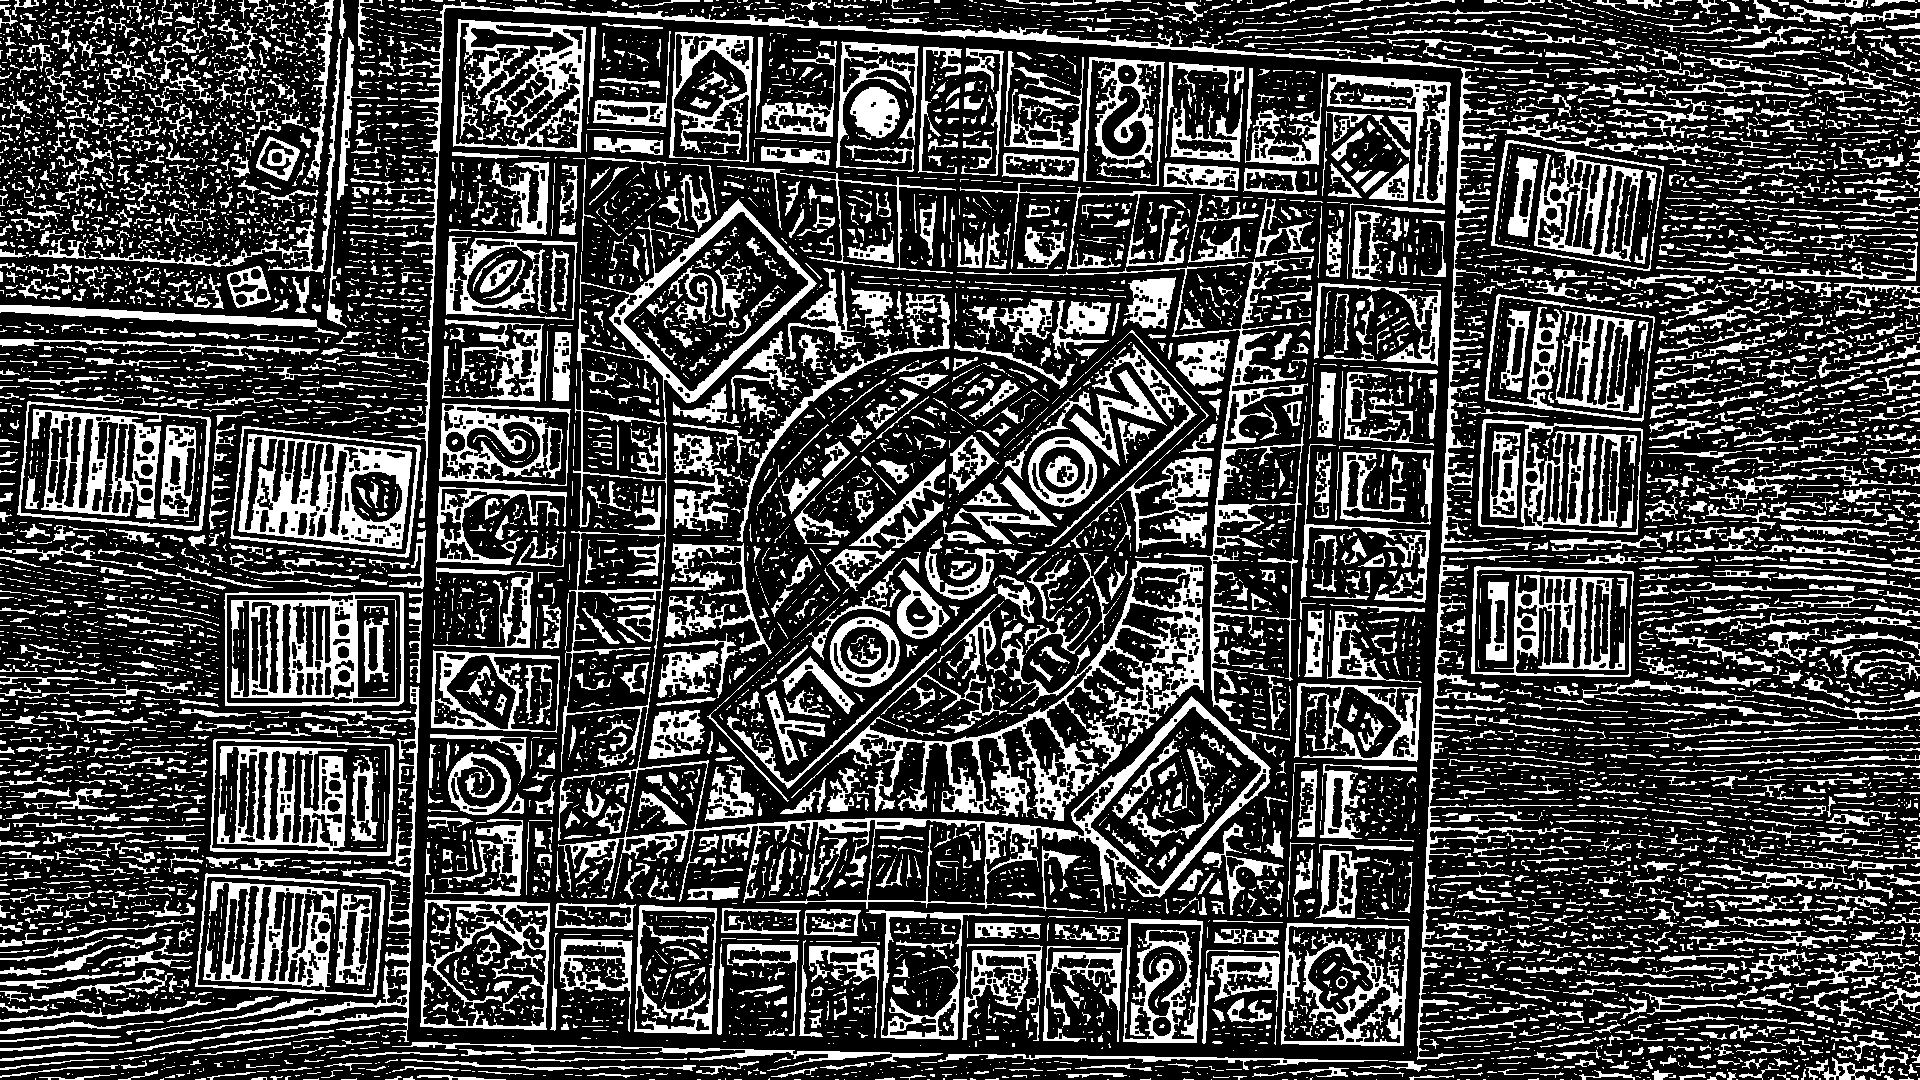

In [6]:
def get_threshold_edges(img: np.ndarray) -> np.ndarray:
    img_gs = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresholded = cv2.adaptiveThreshold(img_gs, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
    thresholded = cv2.erode(thresholded, kernel=np.ones((3, 3), np.uint8), iterations=1)
    return thresholded

showarray(get_threshold_edges(img))

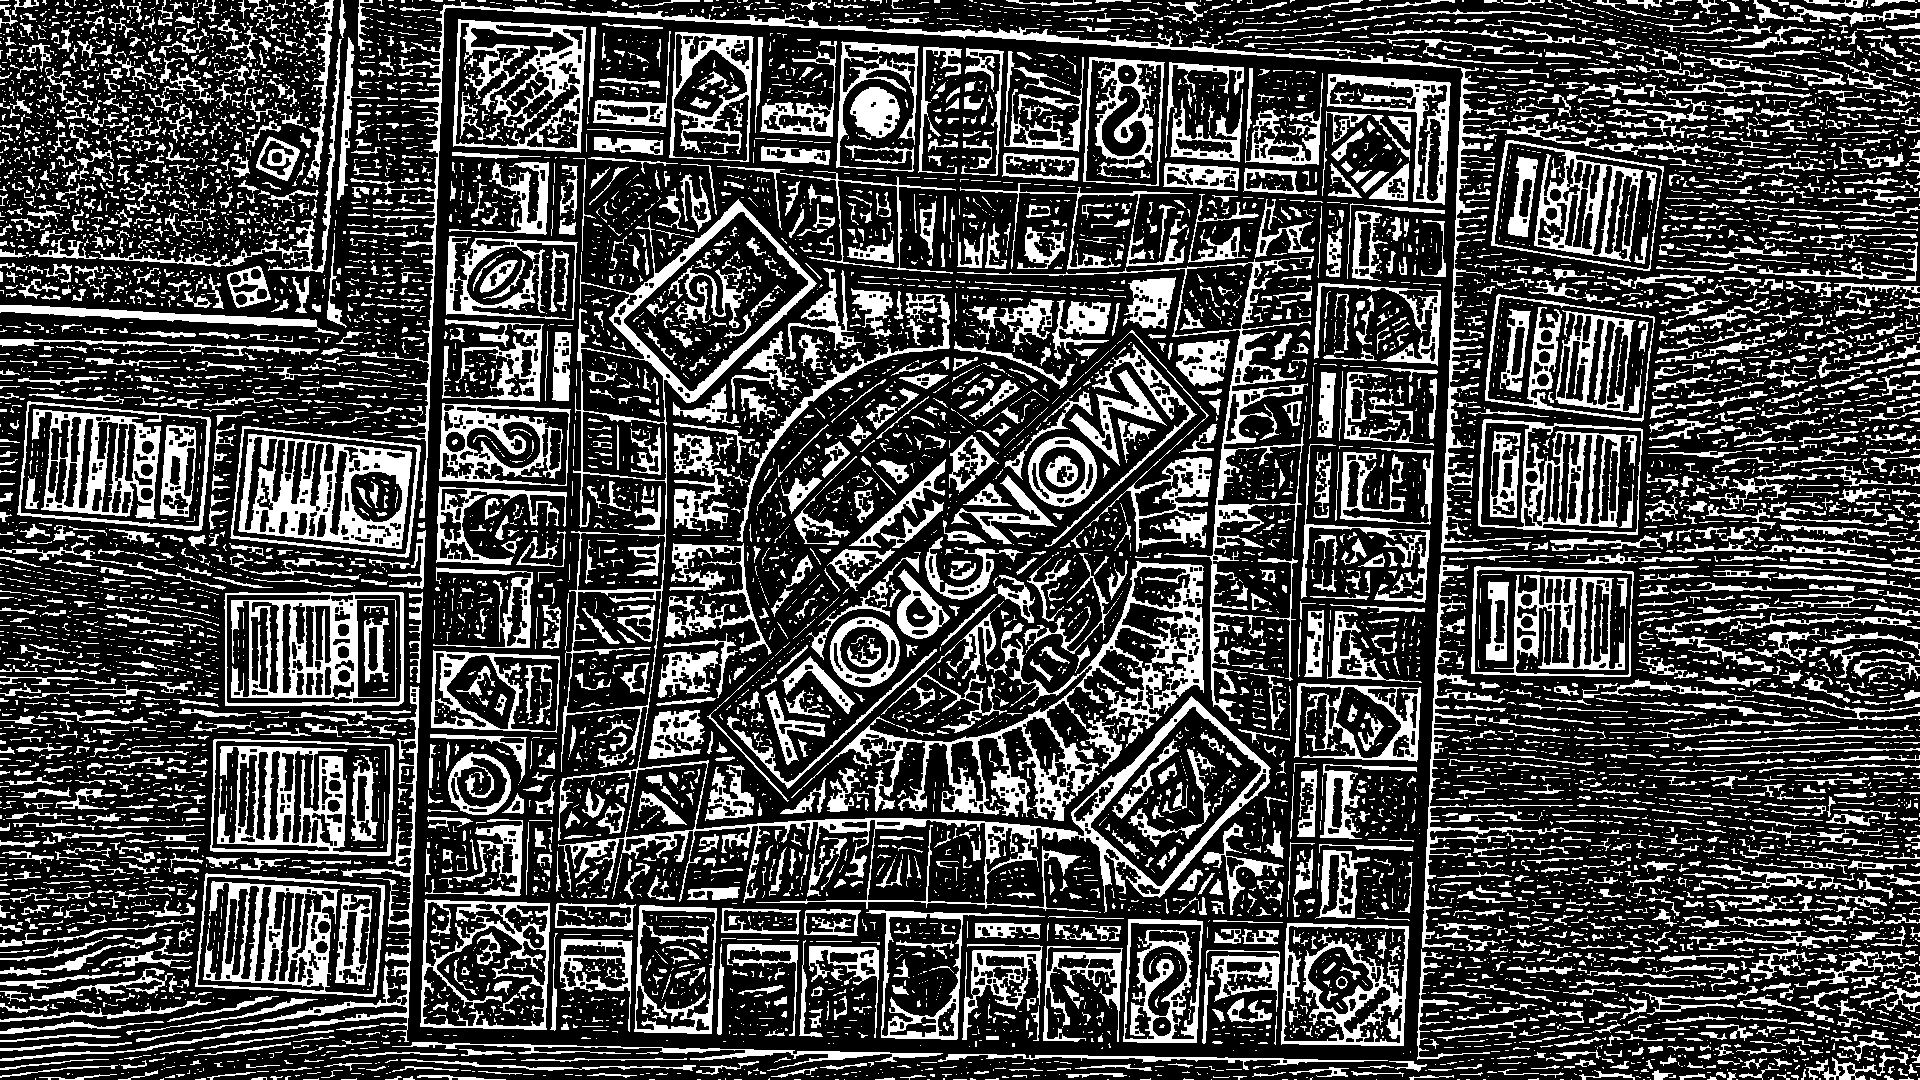

In [7]:
img_2 = cv2.imread("Easy_2_0.jpg")
showarray(get_threshold_edges(img_2))

In [8]:
class SupCardsAnalyzer(CardsAnalyzer):
    def analyze_job(self, frame: np.ndarray, **kwargs) -> None:
        edges = self.edge_detector(frame)
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        self.contours = self.contour_filter(contours)

    def mutate_frame(self, frame: np.ndarray) -> np.ndarray:
        edges = self.edge_detector(frame)
        frame = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
        return super().mutate_frame(frame)


cards_analyzer = CardsAnalyzer(
    # lambda img: get_clear_edges(img, 190, 310),
    get_threshold_edges,
    filter_contours,
    threaded=True,
)
# edges_analyzer = EdgesAnalyzer()
# similarity_analyzer = SimilarityAnalyzer(threshold=0.9999, history_size=10)
processor = LiveFrameProcessor("feed", 800, 400)
with VideoHandler("data/recordings/Medium_3.mp4") as vh:
    first_frame = vh.get_frame(0)
    image_matcher = ImageMatcher(first_frame, board_image)
    matches = image_matcher.get_matches()
    homographer = Homographer(image_matcher.kp_ref, image_matcher.kp_match, matches)
    homography, _ = homographer.get_inverse_homography()
    dst_rect = features.get_board_min_rect_from_homography(homography, board_image)
    additional_context = dict(board_points=cv2.boxPoints(dst_rect))
    vh.go_through_video(processor, [cards_analyzer], additional_context=additional_context, context_processor=lambda context: print(context["fps"]))

23.23198769507726
74.58734555526195
71.00810194559547
77.79376886909476
2.0227527317656726
51.18493088906167
48.594406784183846
50.55535058804707
48.72083462703543
42.6170263996926
50.439581019226225
49.823872672644804
53.052368026844626
52.63268709235283
37.07933494481897
39.08417959188963
28.424110547879266
35.04431347200035
37.20459566272451
35.745307559358274
44.17605048208009
36.39950643079935
36.10694870530467
39.291650189053286
30.6815288171453
39.88481267539527
40.020971111273326
38.178284916869686
42.331984329043316
41.83592797204902
40.978064408667166
44.28541039401241
43.77747033992644
49.36760105419424
45.83539592140095
45.2249261031453
35.74083604019178
38.54975797635907
36.474252783893064
42.36336755393972
37.504031679176386
40.79368179985906
41.17513834652241
28.529368069486193
41.810914244509675
41.745112520093635
38.09814083959176
30.350763769536183
36.32823277678057
40.025456160294276
40.73701393934486
41.94366956464962
44.12497951627343
43.863689162476476
45.52386593